# Building a Metallic Glass Cluster Simulation

This notebook is just a nice easy testing ground for making a metallic glass cluster simulation.  Hopefully eventually it will make it into a more organized form (some python project...)


It is also my way of testing some of the capabilities of different projects and working my way through things like the multislice code.

Carter Francis csfrancis@wisc.edu
Date: Thursday June 10th, 2021

In [1]:
import ase
from ase.io.cif import read_cif
from abtem import *
from ase.cell import Cell
from abtem.structures import orthogonalize_cell
import hyperspy.api as hs

In [2]:
from abtem import __version__
print('current version:', __version__)

current version: 1.0.0beta22


In [3]:
from ase.geometry import get_distances
import numpy as np
import matplotlib.pyplot as plt
def add_nanocrystal(atoms, cluster, center, min_bond_len=2):
    # getting the maximum extent of the cluster...
    diameter = cluster.get_all_distances()
    diameter = np.max(diameter)
    # make sure cluster is centered... 
    cluster.translate(-cluster.get_center_of_mass())
    cluster.translate(center)
    print(cluster.get_center_of_mass())
    #find all atoms that ma
    cluster.set_tags(1)
    t= np.array([diameter/1.5 > np.linalg.norm(c-center) for c in atoms.get_positions()])
    dists =get_distances(atoms[t].get_positions(), cluster.get_positions())[0]
    s = atoms[t]
    dists = np.linalg.norm(dists, axis=2)
    min_dists = np.min(dists, axis=1)
    plt.hist(min_dists)
    t[t]= t[t]*(min_dists<min_bond_len)
    del atoms[t]
    atoms.extend(cluster)
    print(len(atoms))
    return atoms

In [4]:
from ase.cluster.icosahedron import Icosahedron

## --Creating 2 Clusters--

This is just me playing around with creating two clusters to see how building a novel strucuture might work

In [5]:
cluster = Icosahedron("Pd", noshells=3)
cluster2= Icosahedron("Pd", noshells=3)
cluster2.translate([9,9,9])# moving one of the clusters

In [6]:
cluster.extend(cluster2) # Combining the two clusters

The vizualization tools for ase are ***very*** nice.  And are particularily useful when trying to figure out exactly what you have created and giving you very nice set up for when you simulate the strucuture

Cell([0.0, 0.0, 0.0])


<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

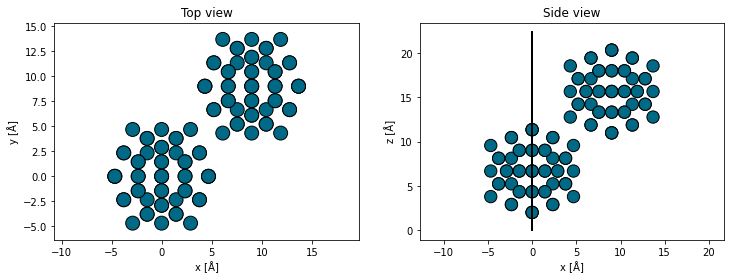

In [7]:
cluster = orthogonalize_cell(cluster)
print(cluster.cell)
cluster.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(cluster, ax=ax1, title='Top view')
show_atoms(cluster, ax=ax2, plane='xz', title='Side view')

**Aside**

An important part of some simulation is the simulation box.  It gives us some reference point and is used to set up the coordinates in a simulation...

Using the center function with some vacuum value helps us to define any size simulation we want.

From the point of view of a multislice simulation the size of the simulation ***is very important*** if you want to increase the resolutioin of your simulations.

In [8]:
cluster.center(vacuum=20)

Cell([58.35935485991741, 58.35935485991741, 22.359354859917413])


<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

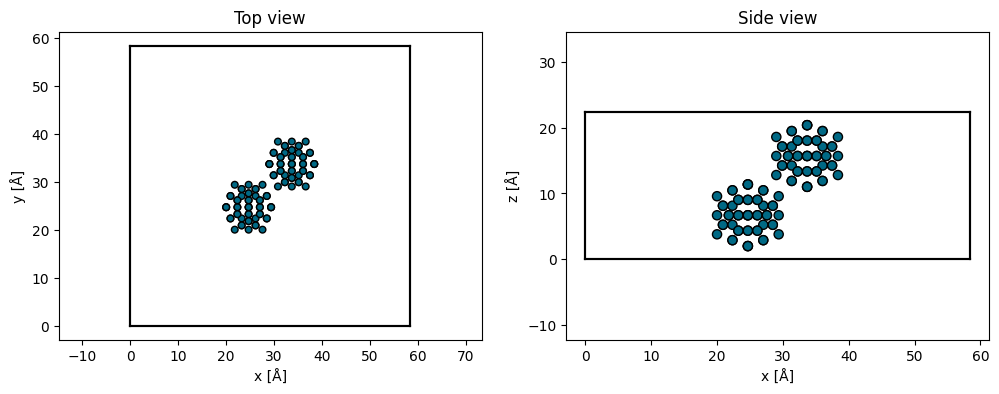

In [10]:
%matplotlib qt5
cluster = orthogonalize_cell(cluster)
print(cluster.cell)
cluster.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(cluster, ax=ax1, title='Top view')
show_atoms(cluster, ax=ax2, plane='xz', title='Side view')

## Defining a Potential

We have to define an electrostatic potential based on the atomic poisitions.  Think of this as kind of like making a 3-D potential space from the atoms in the simulation.  We need something which is ?pixilated? rather than have discrete atoms. 



In [11]:
potential = Potential(cluster, 
                      gpts=1024,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build(pbar=False)

### Defining a Probe

For our probe we are interested in a probe:

**energy:** 200 keV

**Semiangle:**

|Semi-Angle |Diameter  |
--- | --- | 
|5 mrad|0.5 nm|
|2.5 mrad|1.0 nm|
|1.25 mrad| 2 nm|

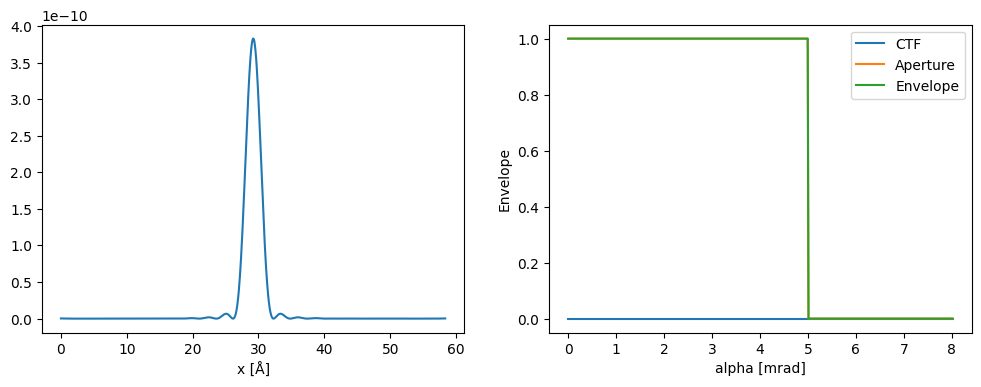

In [12]:
probe = Probe(energy=200e3,
              semiangle_cutoff=5,
              rolloff=0, defocus=0, Cs=0, focal_spread=0)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
probe.profile().show(ax=ax1);
probe.ctf.show(ax=ax2);
detector = PixelatedDetector(max_angle=25) # About 10 nm^-1

In [13]:
def max_k_range(k, wavelength=0.00251):
    return np.arctan(k*wavelength)*1000
max_k_range(10)

25.094730907938388

In [14]:
print(probe.ctf.nyquist_sampling * .9)

1.128570314279781


In [15]:
gridscan = GridScan(start=[10, 10], end=[50,50], sampling=2)

### Creating Probe Positions

It is also kind of nice to look at the probe positions on the sample. In order to get a good idea of where you are actually simulating.

The figure below shows the probe positions which we are going to use to probe the strucuture.

(The Probe sizes aren't correct here but what can you do...)

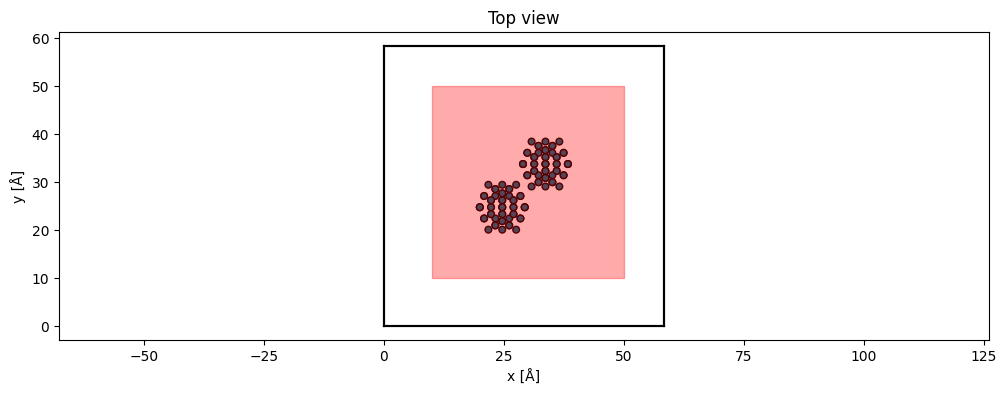

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,4))

show_atoms(cluster, ax=ax1, title='Top view')
gridscan.add_to_mpl_plot(ax1)

### Running the simulation--

Now we can run the multislice simulation.  It is fairly easy, all we need to do is create a measurement object using the defined probe, scanning, detector and atomic potential.

In [18]:
measurement = probe.scan(gridscan, detector, potential)

Scan:   0%|          | 0/400 [00:00<?, ?it/s]

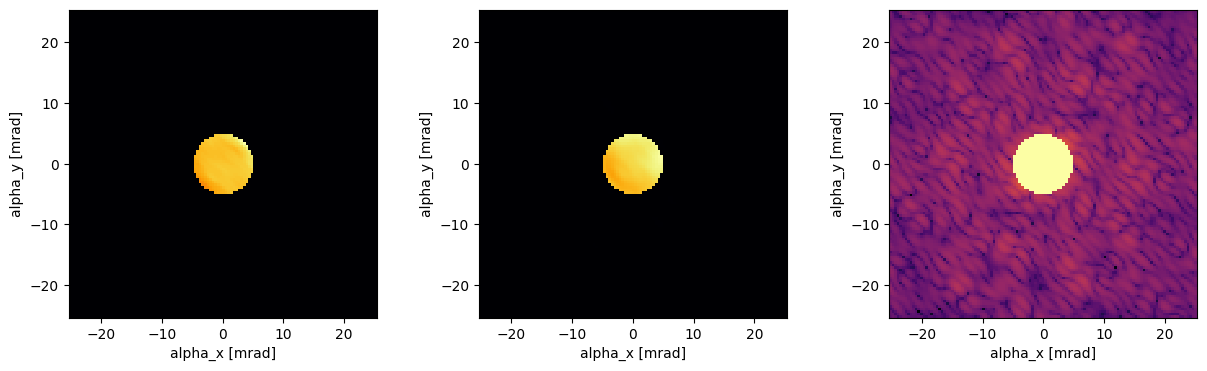

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

measurement[5, 5].show(cmap='inferno', ax=ax1)
measurement[10, 10].show(cmap='inferno', ax=ax2)
measurement[1, 1].show(cmap='inferno', ax=ax3, power=.025); # displayed on power scale

In [20]:
sig = hs.signals.Signal2D(measurement.array)

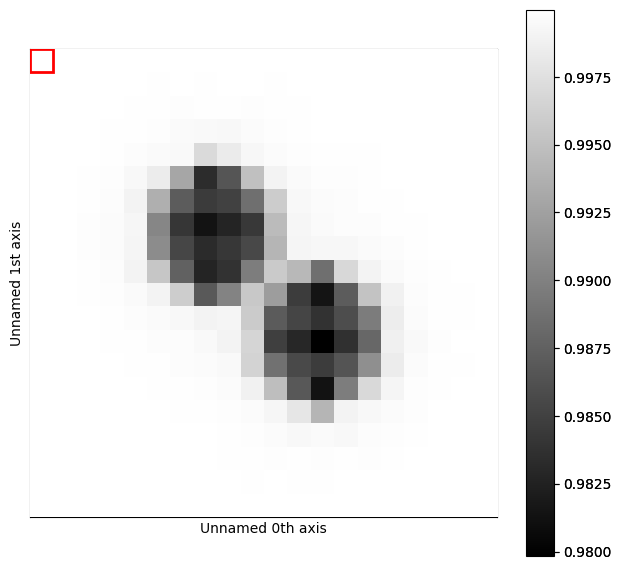

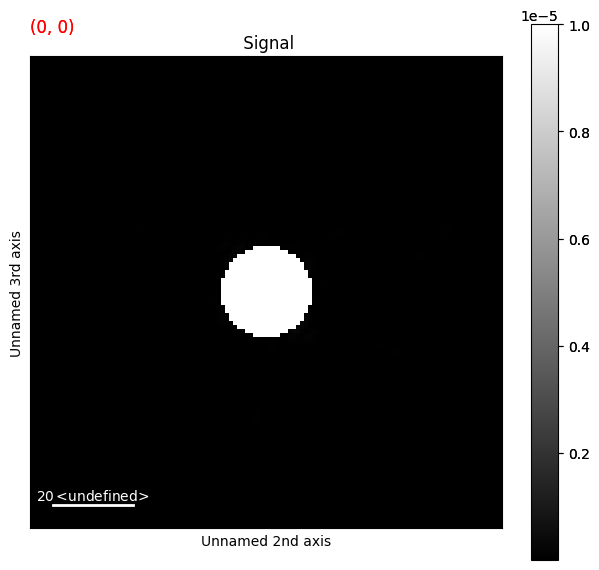

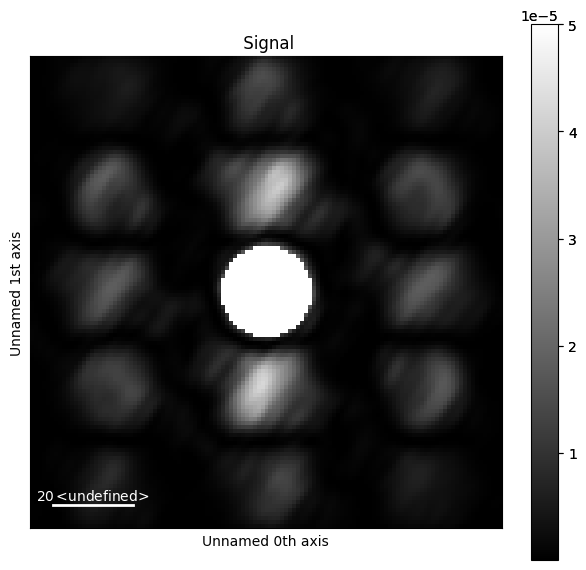

In [29]:
%matplotlib qt5
sig.plot(vmax=0.00001,)
sig.inav[7,8].plot(vmax=0.00005)

In [4]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.verlet import VelocityVerlet
from ase import units

# Set up a crystal
atoms = ase.io.read("Si2Pd9.cif")

In [5]:
atoms = ase.build.bulk("Pd").repeat((20,20,20))

In [6]:
atoms.cell

Cell([[0.0, 38.9, 38.9], [38.9, 0.0, 38.9], [38.9, 38.9, 0.0]])

In [7]:
atoms.cell = Cell([[40,0,0],[0,40,0],[0,0,80]])

Cell([40.0, 40.0, 80.0])


<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

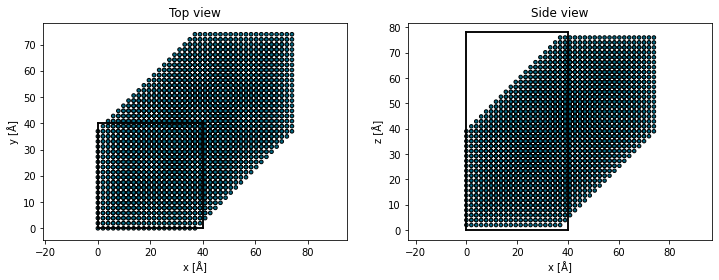

In [8]:
atoms = orthogonalize_cell(atoms)
print(atoms.cell)
atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [9]:
from ase.cluster.cubic import FaceCenteredCubic
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [4, 5, 3]
cluster = FaceCenteredCubic('Pd', surfaces, layers)

[15. 15. 15.]
7935


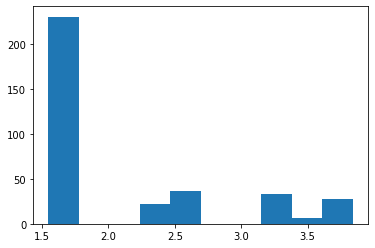

In [10]:
shell =add_nanocrystal(atoms,cluster,(15,15,15))

In [11]:
potential = Potential(atoms, 
                      gpts=1024,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build(pbar=False)

<IPython.core.display.Javascript object>


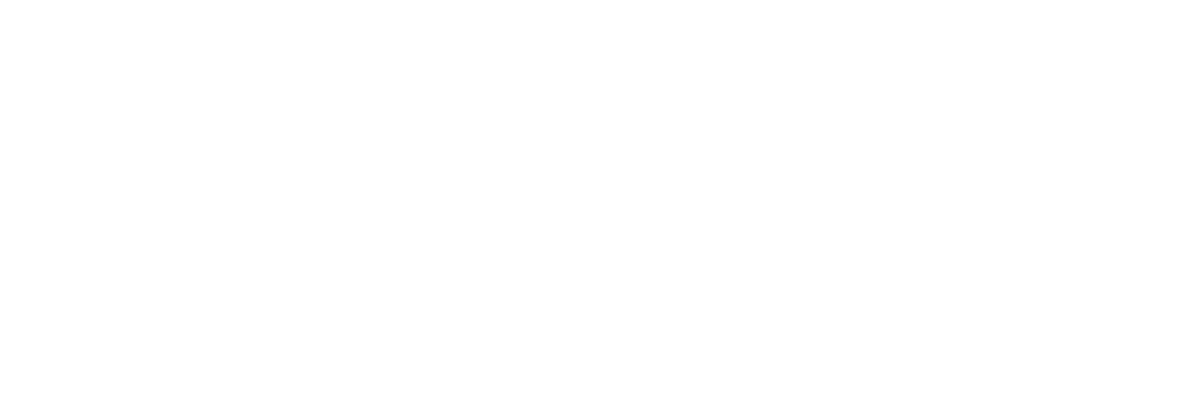

<IPython.core.display.Javascript object>


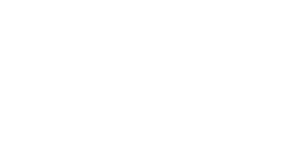

In [38]:
probe = Probe(energy=200e3, semiangle_cutoff=25, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
probe.profile().show(ax=ax1);
probe.ctf.show(ax=ax2);

In [20]:
detector = PixelatedDetector(max_angle='valid')

In [21]:
potential.extent[0]

40.0

In [22]:
repetitions = (8, 5, 1)
scan_end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=scan_end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

Scan:   0%|          | 0/77 [00:00<?, ?it/s]

In [23]:
print(measurement, measurement.array.shape)

<abtem.measure.Measurement object at 0x7f1984b51e48> (7, 11, 477, 477)


In [29]:
import hyperspy.api as hs
measurement.array

array([[[[4.84769025e-08, 1.16010277e-08, 2.20726442e-08, ...,
          8.11765730e-08, 1.59634492e-08, 4.15108214e-09],
         [1.16008243e-08, 2.66270028e-09, 4.04414635e-08, ...,
          6.60662802e-10, 9.45134637e-09, 1.07021476e-08],
         [2.20725784e-08, 4.04419076e-08, 1.20683179e-08, ...,
          2.51863721e-08, 1.36410048e-08, 7.98069255e-09],
         ...,
         [8.11788823e-08, 6.60734245e-10, 2.51864876e-08, ...,
          1.53527058e-09, 1.41531533e-08, 3.26157190e-09],
         [1.59631224e-08, 9.45126200e-09, 1.36408849e-08, ...,
          1.41536924e-08, 1.73099792e-08, 2.74241145e-08],
         [4.15073842e-09, 1.07019309e-08, 7.98082045e-09, ...,
          3.26142069e-09, 2.74239760e-08, 1.46882706e-09]],

        [[4.89001835e-08, 1.65381486e-08, 2.04888412e-10, ...,
          3.21132916e-08, 2.90581834e-08, 2.90831075e-08],
         [2.28873471e-08, 3.64654040e-09, 1.89767810e-08, ...,
          1.64593743e-08, 1.82985058e-08, 1.18051977e-08],
        

In [31]:
s = hs.signals.Signal2D(measurement.array)

<IPython.core.display.Javascript object>


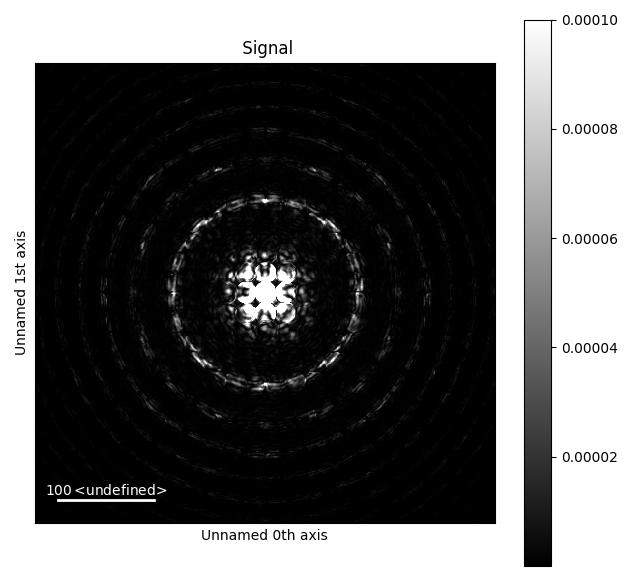

<IPython.core.display.Javascript object>


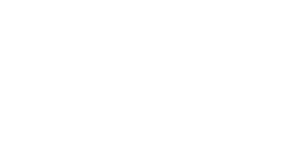

In [37]:

s.inav[4,5].plot(vmax=0.0001)

In [31]:
"""Demonstrates molecular dynamics with constant temperature."""
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase import units
from asap3 import EMT  # Way too slow with ase.EMT !
size = 10

T = 2500  # Kelvin

# Describe the interatomic interactions with the Effective Medium Theory
atoms.calc = EMT()

# We want to run MD with constant energy using the Langevin algorithm
# with a time step of 5 fs, the temperature T and the friction
# coefficient to 0.02 atomic units.
dyn = Langevin(atoms, 5 * units.fs, T * units.kB, 0.002)


def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


dyn.attach(printenergy, interval=50)

# We also want to save the positions of all atoms after every 100th time step.
traj = Trajectory('moldyn3.traj', 'w', atoms)
dyn.attach(traj.write, interval=50)

# Now run the dynamics
printenergy()
dyn.run(5000)

/home/carter/anaconda3/lib/python3.7/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Energy per atom: Epot = 0.046eV  Ekin = 0.000eV (T=  0K)  Etot = 0.046eV
Energy per atom: Epot = 0.046eV  Ekin = 0.000eV (T=  0K)  Etot = 0.046eV
Energy per atom: Epot = 0.037eV  Ekin = 0.036eV (T=281K)  Etot = 0.073eV
Energy per atom: Epot = 0.051eV  Ekin = 0.051eV (T=391K)  Etot = 0.102eV
Energy per atom: Epot = 0.064eV  Ekin = 0.064eV (T=499K)  Etot = 0.128eV
Energy per atom: Epot = 0.075eV  Ekin = 0.079eV (T=610K)  Etot = 0.154eV
Energy per atom: Epot = 0.089eV  Ekin = 0.089eV (T=690K)  Etot = 0.178eV
Energy per atom: Epot = 0.098eV  Ekin = 0.102eV (T=792K)  Etot = 0.200eV
Energy per atom: Epot = 0.111eV  Ekin = 0.112eV (T=864K)  Etot = 0.222eV
Energy per atom: Epot = 0.118eV  Ekin = 0.124eV (T=962K)  Etot = 0.242eV
Energy per atom: Epot = 0.129eV  Ekin = 0.132eV (T=1023K)  Etot = 0.261eV
Energy per atom: Epot = 0.134eV  Ekin = 0.144eV (T=1115K)  Etot = 0.278eV
Energy per atom: Epot = 0.146eV  Ekin = 0.150eV (T=1158K)  Etot = 0.296eV
Energy per atom: Epot = 0.149eV  Ekin = 0.162eV 

KeyboardInterrupt: 

In [104]:
atoms.cell

Cell([40.0, 40.0, 77.91])

In [105]:
np.mgrid[0:10,0:10]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]],

       [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])

In [106]:
pos = atoms[1].position[:2]

In [107]:
np.abs(atoms.cell[~np.eye(3, dtype=bool)]) > 1e-12

array([False, False, False, False, False, False])

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

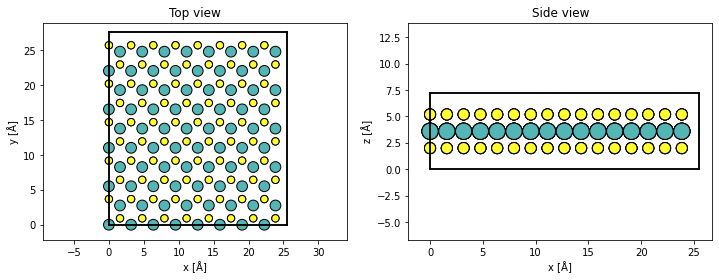

In [18]:
from abtem.waves import Probe

probe = Probe(energy=300e3, semiangle_cutoff=20, rolloff=.1, sampling=.05)
from ase.io import read

srtio3_110 = read('Si2Pd9.cif')

pos = srtio3_110[1].position[:2]

In [22]:
from abtem.structures import orthogonalize_cell

In [23]:
MaxwellBoltzmannDistribution(atoms, temperature_K=200)
from asap3 import EMT
dyn = VelocityVerlet(atoms, 5 * units.fs)  # 5 fs time step.
atoms.calc = EMT()


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Atoms(symbols='Pd8000', pbc=True, cell=[40.0, 40.0, 40.0], momenta=..., tags=..., calculator=EMT(...))

TypeError: expected dtype object, got 'numpy.dtype[float64]'

In [298]:
shell

Atoms(symbols='Pd2299Si473', pbc=True, cell=[30.138736, 36.709136, 38.223176], spacegroup_kinds=..., tags=...)

In [258]:
print(len(atoms))
print(len(cluster))

2816
165


In [260]:
cluster_dims = cluster.get_cell()
cell_dims = atoms.get_cell()

In [261]:
cell_dims/2

array([[15.069368,  0.      ,  0.      ],
       [ 0.      , 18.354568,  0.      ],
       [ 0.      ,  0.      , 19.111588]])

In [ ]:
atoms.get_tags()

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
import numpy as np
from scipy.optimize import linprog

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success


In [10]:
# getting the maximum extent of the cluster...
diameter = cluster.get_all_distances()
center= (0,0,0)
print(np.max(diameter))
# make sure cluster is centered... 
cluster.translate(-cluster.get_center_of_mass())
print(cluster.get_center_of_mass())
#find all atoms that maybe in the range?
t= [diameter/2 > np.linalg.norm(c-center) for c in atoms.get_positions()]
atoms[t]

Atoms(symbols='Pd128Si26', pbc=True, cell=[150.69368, 183.54568, 95.55794], spacegroup_kinds=...)

In [267]:
len(atoms)

2683

In [268]:
atoms.get_tags==1

False

[5. 5. 5.]
2848


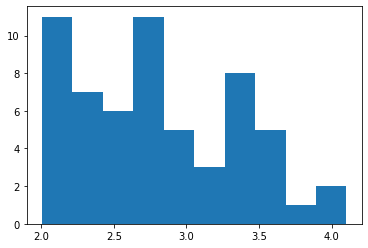

In [270]:
from ase.visualize import view

In [217]:
len(shell)

204

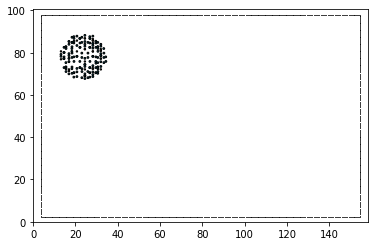

In [207]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots()
plot_atoms(shell, ax, radii=0.3, rotation=('90x,0y,0z'))
plt.show()

[-6.47445159e-18  2.84875870e-16 -4.85583869e-18]
255
176000
165


In [7]:
import time
tick = time.time()
import numpy as np
center=(0,0,0)
t = [8 > np.linalg.norm(c-center) for c in atoms.get_positions()]
tock = time.time()
print(tock-tick)
inCluster = atoms[t]

0.9619834423065186


In [ ]:
len(inCluster)

In [ ]:
import time
tick = time.time()
in_hull(cluster.get_positions(),(0,0,0))
tock =  time.time()
print((tock-tick)*len(atoms))

In [ ]:
len(inCluster)

In [ ]:
t = [in_hull(cluster.get_positions(),c) for c in atoms.get_positions()]
inCluster = atoms[t]

In [ ]:
atoms.extend(cluster)

In [ ]:
atoms.get_distances(atoms.get_tags()==1,2)

In [ ]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=('90x,45y,0z'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=('90x,0y,0z'))
plt.show()